**Cox-Ingersoll-Ross**

El modelo CIR se utiliza principalmente para modelar tasas de interés. Su característica principal es que la volatilidad depende de la raíz del nivel actual, lo que impide que las tasas se vuelvan negativas (si se cumple la condición de Feller $2\theta\mu \ge \sigma^2$).

$$dS_t = \theta(\mu - S_t)dt + \sigma \sqrt{S_t} dW_t$$

Para usar cálculo ordinario (redes neuronales), convertimos la ecuación a Stratonovich restando el término de corrección de Itô al drift.Término de Difusión: $g(S) = \sigma \sqrt{S}$

Corrección de Itô: $\frac{1}{2} g(S) g'(S) = \frac{1}{2} (\sigma \sqrt{S}) (\frac{\sigma}{2\sqrt{S}}) = \frac{\sigma^2}{4}$

La ecuación residual que minimiza la PINN es:$$\frac{dS}{dt} = \underbrace{\theta(\mu - S) - \frac{\sigma^2}{4}}_{\text{Drift Modificado}} + \sigma \sqrt{S} \frac{dW}{dt}$$

In [ ]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

seed = 123 
torch.manual_seed(seed)
np.random.seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def dWdt_kl_torch(t, zetas, T):
    N, n_terms = zetas.shape
    k = torch.arange(1, n_terms + 1, device=t.device).view(1, -1)
    t_hat = t / T
    arg = (k - 0.5) * math.pi * t_hat
    cos_term = torch.cos(arg)
    sum_term = (zetas * cos_term).sum(dim=1, keepdim=True)
    factor = math.sqrt(2.0 / float(T))
    return factor * sum_term

In [ ]:
class CIRSPINN(nn.Module):
    def __init__(self, T, n_terms, hidden_dim=64, n_hidden=3):
        super().__init__()
        self.T  = T
        
        in_dim = 1 + n_terms 
        out_dim = 1

        layers = [nn.Linear(in_dim, hidden_dim), nn.Tanh()]
        for _ in range(n_hidden - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
        layers += [nn.Linear(hidden_dim, out_dim)]
        
        self.net = nn.Sequential(*layers)
        
        self.softplus = nn.Softplus(beta=5) 

    def forward(self, t, zetas):
        t_norm = t / self.T
        x = torch.cat([t_norm, zetas], dim=1)
        raw_out = self.net(x)
        return self.softplus(raw_out)

In [ ]:
def residual_pde_cir(model, t, zetas, theta, mu, sigma, T):

    t_req = t.clone().detach().requires_grad_(True)
    z_req = zetas.clone().detach()

    s_pred = model(t_req, z_req)

    ds_dt = torch.autograd.grad(
        s_pred,
        t_req,
        grad_outputs=torch.ones_like(s_pred),
        create_graph=True
    )[0]

    dWdt = dWdt_kl_torch(t_req, z_req, T)


    drift_ito = theta * (mu - s_pred)
    

    correction = 0.25 * (sigma ** 2)
    
    drift_stratonovich = drift_ito - correction
    

    diffusion = sigma * torch.sqrt(s_pred + 1e-8) * dWdt 


    rhs = drift_stratonovich + diffusion
    res = ds_dt - rhs
    
    return res

In [ ]:

def pinn_loss_cir(model, theta, mu, sigma, S0, T, n_terms,
                   N_colloc=1024, N_ic=128, device="cpu"):


    t_colloc = torch.rand(N_colloc, 1, device=device) * T
    z_colloc = torch.randn(N_colloc, n_terms, device=device)

    res = residual_pde_cir(model, t_colloc, z_colloc, theta, mu, sigma, T)
    loss_pde = torch.mean(res**2)


    t_ic = torch.zeros(N_ic, 1, device=device)
    z_ic = torch.randn(N_ic, n_terms, device=device)
    
    s0_pred = model(t_ic, z_ic)
    loss_ic = torch.mean((s0_pred - S0)**2)

    return loss_pde + loss_ic, loss_pde.detach(), loss_ic.detach()

# Parámetros CIR (Cumpliendo condición de Feller 2*theta*mu > sigma^2 para estabilidad)
S0_val    = 0.05
theta_val = 1.0
mu_val    = 0.05  
sigma_val = 0.10  
T_val     = 1.0
n_terms   = 30

# Verificación Feller
if 2 * theta_val * mu_val > sigma_val**2:
    print("Condición de Feller cumplida: El proceso teóricamente no toca el cero.")
else:
    print("ADVERTENCIA: Condición de Feller NO cumplida. El proceso podría tocar cero.")

S0_t    = torch.tensor(S0_val,    dtype=torch.float32, device=device)
theta_t = torch.tensor(theta_val, dtype=torch.float32, device=device)
mu_t    = torch.tensor(mu_val,    dtype=torch.float32, device=device)
sigma_t = torch.tensor(sigma_val, dtype=torch.float32, device=device)
T_t     = torch.tensor(T_val,     dtype=torch.float32, device=device)

model = CIRSPINN(T_t, n_terms, hidden_dim=128, n_hidden=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("Entrenando CIR-PINN...")
n_epochs = 20000

pbar = range(1, n_epochs + 1)
for epoch in pbar:
    optimizer.zero_grad()
    loss, loss_pde, loss_ic = pinn_loss_cir(
        model, theta_t, mu_t, sigma_t, S0_t, T_t, n_terms,
        N_colloc=1024, N_ic=128, device=device
    )
    loss.backward()
    optimizer.step()

    if epoch % 2000 == 0:
         print(f"Epoch {epoch:5d} | Loss: {loss.item():.4e} | PDE: {loss_pde.item():.4e}")

Condición de Feller cumplida: El proceso teóricamente no toca el cero.
Entrenando CIR-PINN...
Epoch  2000 | Loss: 4.4051e-03 | PDE: 1.9064e-03
Epoch  4000 | Loss: 4.3579e-03 | PDE: 1.8587e-03
Epoch  6000 | Loss: 4.2823e-03 | PDE: 1.7852e-03
Epoch  8000 | Loss: 4.1193e-03 | PDE: 1.7686e-03
Epoch 10000 | Loss: 3.9344e-03 | PDE: 1.6065e-03
Epoch 12000 | Loss: 3.8018e-03 | PDE: 1.5642e-03
Epoch 14000 | Loss: 3.5228e-03 | PDE: 1.3500e-03
Epoch 16000 | Loss: 3.0633e-03 | PDE: 1.7021e-03
Epoch 18000 | Loss: 1.9612e-03 | PDE: 1.6892e-03
Epoch 20000 | Loss: 8.7922e-04 | PDE: 8.3880e-04


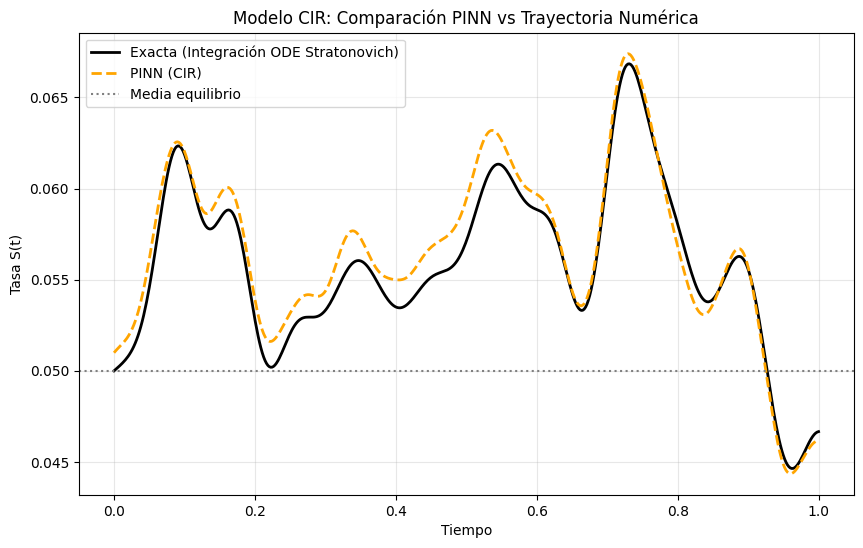

In [ ]:

model.eval()

n_t = 500  
t_plot = torch.linspace(0, T_val, n_t, device=device).view(-1, 1)
z_single = torch.randn(1, n_terms, device=device)
z = z_single.repeat(n_t, 1)


with torch.no_grad():
    S_pinn = model(t_plot, z).cpu().numpy().ravel()


dt = T_val / (n_t - 1)
dWdt_val = dWdt_kl_torch(t_plot, z, T_t).cpu().numpy().ravel()
S_exact_num = [S0_val]
S_curr = S0_val

correction = 0.25 * (sigma_val ** 2) 

for i in range(n_t - 1):
    S_curr = max(S_curr, 0.0) 
    
    drift = theta_val * (mu_val - S_curr) - correction
    diffusion = sigma_val * np.sqrt(S_curr) * dWdt_val[i]
    
    S_curr += (drift + diffusion) * dt
    S_exact_num.append(S_curr)

S_exact_np = np.array(S_exact_num)
t_np = t_plot.cpu().numpy().ravel()

plt.figure(figsize=(10, 6))
plt.plot(t_np, S_exact_np, label="Exacta (Integración ODE Stratonovich)", linewidth=2, color='black')
plt.plot(t_np, S_pinn, "--", label="PINN (CIR)", linewidth=2, color='orange')
plt.axhline(y=mu_val, color='gray', linestyle=':', label='Media equilibrio')
plt.xlabel("Tiempo")
plt.ylabel("Tasa S(t)")
plt.title("Modelo CIR: Comparación PINN vs Trayectoria Numérica")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()